# Testing code for cost function "elasticity" on the annulus

In [2]:
%pylab inline

import dionysus

Populating the interactive namespace from numpy and matplotlib


## Constructing the annulus and combuting the cocycle

(-2.09511859839671, 2.1097636827914448, -2.11312614106959, 2.0317591771865344)

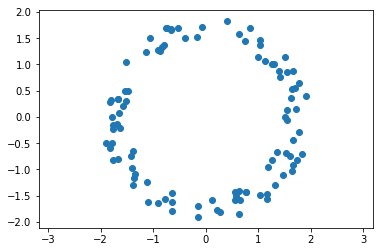

In [3]:
R = 1.5
d = .5
n = 100

# r in [0,1]
# th in [0,2pi)

from math import sin, cos, pi
from random import uniform
def rand_annulus_pt():
    r = uniform(0,1)
    th = uniform(0,2*pi)
    return (R+r*d) * cos(th), (R+r*d) * sin(th)
annulus = np.array([(rand_annulus_pt()) for x in range(100)])
plt.scatter(*annulus.T)
plt.axis('equal')

In [4]:
prime = 19
vr = dionysus.fill_rips(annulus, 2, 4.)
cp = dionysus.cohomology_persistence(vr, prime, True)
dgms = dionysus.init_diagrams(cp, vr)

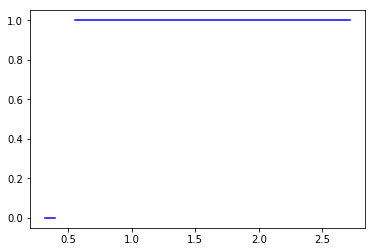

In [5]:
dionysus.plot.plot_bars(dgms[1], show=True)

In [6]:
bars = [bar for bar in dgms[1] if bar.death > 1.]
bars

[(0.552149,2.71544)]

In [7]:
cocycles = [cp.cocycle(bar.data) for bar in bars]
vr_8 = dionysus.Filtration([s for s in vr if s.data <= 1.0])
coords = [dionysus.smooth(vr_8, cocycle, prime) for cocycle in cocycles]

(-2.09511859839671, 2.1097636827914448, -2.11312614106959, 2.0317591771865344)

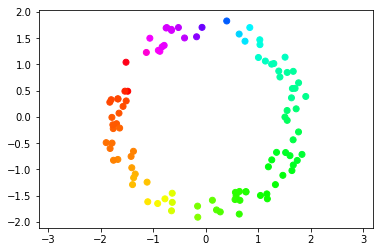

In [8]:
# subplot(121)#, projection="3d")
scatter(*annulus.T, c=coords[0], cmap="hsv")
plt.axis('equal')

# subplot(122)#, projection="3d")
# scatter(*annulus.T, c=coords[1], cmap="hsv")

# Scipy Test

In [9]:
D = {}
data = {}
indexing = {}
ix = [0]*50
thr = 3
for s in vr:
    if s.dimension() == 0:
        continue
    elif s.data > thr:
        break
    D.setdefault(s.dimension(),[[],[]])
    data.setdefault(s.dimension(),[])
    indexing.setdefault(s.dimension(),{})
    indexing.setdefault(s.dimension()-1,{})
    if not s in indexing[s.dimension()]:
        indexing[s.dimension()][s] = ix[s.dimension()]
        ix[s.dimension()] += 1
    for dat, k in enumerate(s.boundary()): 
        if not k in indexing[s.dimension()-1]:
            indexing[s.dimension()-1][k] = ix[s.dimension()-1]
            ix[s.dimension()-1] += 1
        D[s.dimension()][0].append(indexing[s.dimension()][s]) #rows
        D[s.dimension()][1].append(indexing[s.dimension()-1][k]) #cols
        data[s.dimension()].append(1. if dat % 2 == 0 else -1.)
import scipy as sp
CBd = [sp.sparse.csr_matrix((data[d], (D[d][0], D[d][1]))).todense() for d in range(1,max(D.keys())+1)]

In [10]:
from scipy.optimize import minimize

In [11]:
l2_cocycle = [0]*len(coords[0])
for i, coeff in enumerate(coords[0]):
    l2_cocycle[indexing[0][dionysus.Simplex([i],0)]] = coeff
l2_cocycle = np.array(l2_cocycle)
bdry = CBd[0]
n, m = CBd[0].shape
f = np.zeros((n,1))
for c2 in cocycles[0]:
    f[indexing[1][vr[c2.index]]] = c2.element

## 2-norm

In [12]:
def grad(Z,L = 1.,F = f, B = bdry):
    coeff_A = 2 + L/np.linalg.norm(B*Z.reshape(Z.shape[0],1),ord=2)
    dz = B*Z.reshape(Z.shape[0],1)
    return np.array(coeff_A * B.T * dz - 2 * np.diag(Z) * B.T * F).flatten()

In [13]:
grad(l2_cocycle)

array([ 1.42682109e+02,  7.55522125e+01,  6.03964601e+00,  5.47590441e+00,
        1.81469316e+02,  1.65977191e+02,  8.42131959e+01,  2.95938909e+02,
        3.00418444e+02,  2.83068902e+02, -9.43927498e-01, -1.28166671e+00,
        1.40199587e+02,  1.40730228e+02, -6.11519660e+00, -6.11519660e+00,
        3.71828863e+00,  6.72169929e-01,  1.36702853e+02,  1.35139645e+01,
        6.98549998e+00,  6.81150085e+00, -4.13105280e+01, -3.91235940e+01,
       -2.08092497e+01,  6.09866702e+00, -6.12049530e+00, -6.67842017e+00,
       -3.31792351e+00, -4.35729273e+00,  6.47473967e+00,  5.84408978e+00,
        4.76449147e+00,  6.53377748e+01,  8.06206711e+01,  1.08722742e+00,
        3.23710362e+00,  5.14676071e+00,  1.21708013e+00,  1.28938592e+00,
       -1.15379556e+01,  9.13173761e-01, -2.16768081e-01,  9.42966497e+01,
       -3.86699567e+01,  1.63095218e-01, -1.42637459e-01,  4.52460591e+01,
       -3.61306818e+01, -3.61306818e+01,  2.72398290e-01, -2.92547537e+00,
       -2.96401468e+00, -

In [14]:
def cost(Z,L = 1.,F = f, B = bdry):
    return np.sum(np.square(F - B*Z.reshape(Z.shape[0],1))) + L*np.linalg.norm(B*Z.reshape(Z.shape[0],1),ord=2)

In [15]:
cost(l2_cocycle)
# ??dionysus.smooth

54728.11776636817

In [16]:
res = minimize(cost, l2_cocycle, method='BFGS', jac = grad)

Text(0.5, 1.0, 'smoothed values mod 1')

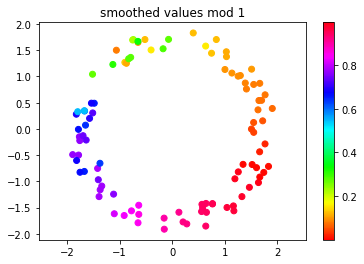

In [17]:
Zv = np.array(res.x).reshape(100,1)
messed_ix = [indexing[0][dionysus.Simplex([n],0)] for n in range(100)]
color = np.mod(Zv.T[:,messed_ix],1)
scatter(*annulus.T, c=color[0], cmap="hsv")
plt.colorbar()
plt.axis('equal')
plt.title('smoothed values mod 1')

Text(0.5, 1.0, 'smoothed values')

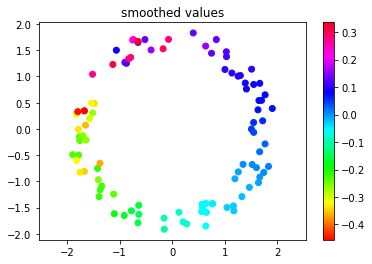

In [18]:
Zv = np.array(res.x).reshape(100,1)
messed_ix = [indexing[0][dionysus.Simplex([n],0)] for n in range(100)]
color = Zv.T[:,messed_ix]
scatter(*annulus.T, c=color[0], cmap="hsv")
plt.colorbar()
plt.axis('equal')
plt.title('smoothed values')

## 1-norm

In [37]:
def grad(Z,L = 1.,F = f, B = bdry, toll = 1e-18):
    dz = B*Z.reshape(Z.shape[0],1)
    ndz = np.sign(np.where(dz<toll, 0, dz))
    return np.array(2 * B.T * dz - 2 * np.diag(Z) * B.T * F + L * B.T * ndz).flatten()

In [38]:
grad(l2_cocycle)

array([139.70547013,  57.57557383,  -1.12776387, -27.6758794 ,
       197.01774663, 181.52562128, 126.76162636, 293.48733952,
       321.60548952, 304.28237227,  39.08223675,   7.75385916,
       187.46852211, 186.00894332,  25.05430743,  -9.94569257,
       -46.08194894, -51.99320982, 135.6144717 , -19.57116237,
        36.79187245, -15.37730369, -89.3985069 , -85.27023231,
       -61.87511386,   8.92962117,  26.0491556 ,  -2.49330443,
       -12.60690186, -19.6098998 ,   7.29526965,  26.68210042,
       -13.36757305,  83.09702662,  99.43021925,  21.05057254,
        10.14085741,  25.00410026,  -1.8166555 , -24.74635392,
       -43.57639507,  21.88786196, -20.2107596 ,  96.26990972,
       -81.79680961,  10.15857446,  -7.13868376,  32.03114659,
       -79.33783384, -75.33783384,  29.26484782,  12.1556144 ,
        -1.88185666,   6.93434289, -24.66766483, -31.68444337,
       -74.10649904, -32.95176801, -34.81262069, -12.28192217,
       -14.31061541,  39.80349122,   9.29818114, 250.31

In [39]:
def cost(Z,L = 1.,F = f, B = bdry):
    return np.sum(np.square(F - B*Z.reshape(Z.shape[0],1))) + L*np.linalg.norm(B*Z.reshape(Z.shape[0],1),ord=1)

In [40]:
cost(l2_cocycle)
# ??dionysus.smooth

55407.52766384231

In [41]:
res = minimize(cost, l2_cocycle, method='BFGS', jac = grad)

Text(0.5, 1.0, 'smoothed values mod 1')

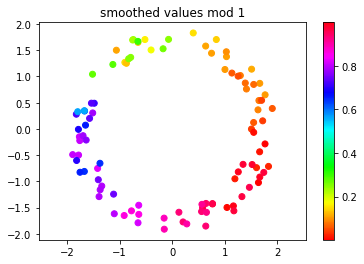

In [42]:
Zv = np.array(res.x).reshape(100,1)
messed_ix = [indexing[0][dionysus.Simplex([n],0)] for n in range(100)]
color = np.mod(Zv.T[:,messed_ix],1)
scatter(*annulus.T, c=color[0], cmap="hsv")
plt.colorbar()
plt.axis('equal')
plt.title('smoothed values mod 1')

Text(0.5, 1.0, 'smoothed values')

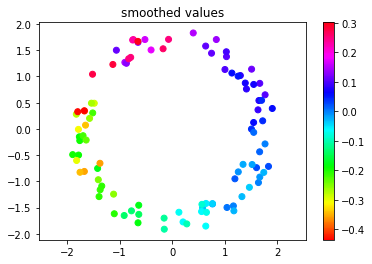

In [43]:
Zv = np.array(res.x).reshape(100,1)
messed_ix = [indexing[0][dionysus.Simplex([n],0)] for n in range(100)]
color = Zv.T[:,messed_ix]
scatter(*annulus.T, c=color[0], cmap="hsv")
plt.colorbar()
plt.axis('equal')
plt.title('smoothed values')